# Import Libraries

This cell imports all the necessary Python libraries for the analysis:
- `wbgapi` for accessing World Bank data
- `pandas` for data manipulation and analysis
- `matplotlib.pyplot` for data visualization
- `StandardScaler`, `PCA`, and `KMeans` from scikit-learn for data preprocessing and machine learning

In [3]:
import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Data Collection

This cell fetches economic and development indicators from the World Bank API for ASEAN countries. The indicators selected are:
- Employment in Industry (% of total employment)
- GDP per capita (current US$)
- Research and development expenditure (% of GDP)
- Government Effectiveness (estimate)
- Regulatory Quality (estimate)
- Human Capital Index

Data is collected for the period 2015-2020 for all 11 ASEAN member countries.

In [4]:
ASEAN_codes = ['IDN', 'MYS', 'SGP', 'THA', 'VNM', 'PHL', 'BRN', 'LAO', 'KHM', 'MMR', 'TLS']

#Fetch 1) Employment in Industry, 2) GDP per capita, 3) R&D Expenditure (2020-2025), 4) Government Effectiveness, 5) Regultory Quality, 6) Human Capital Index
indicators_list = ['SL.IND.EMPL.ZS', 'NY.GDP.PCAP.CD', 'GB.XPD.RSDV.GD.ZS', 'GE.EST', 'RQ.EST', 'HD.HCI.OVRL']

df_indicators = wb.data.DataFrame(
    indicators_list, 
    ASEAN_codes, 
    time=range(2015,2021)
)

df_indicators = df_indicators.reset_index()
print(df_indicators.head())

  economy             series        YR2015        YR2016        YR2017  \
0     BRN  GB.XPD.RSDV.GD.ZS           NaN           NaN           NaN   
1     BRN             GE.EST      1.026417      1.048699      1.107938   
2     BRN        HD.HCI.OVRL           NaN           NaN           NaN   
3     BRN     NY.GDP.PCAP.CD  30625.128774  26663.297295  28024.382458   
4     BRN             RQ.EST      0.836912      0.580996      0.703711   

         YR2018        YR2019        YR2020  
0      0.277640           NaN           NaN  
1      1.213115      1.278817      1.383309  
2           NaN           NaN      0.626391  
3  30988.119027  30426.573066  26834.359223  
4      0.676745      0.624943      0.904901  


# Explore Government Effectiveness Indicator

This cell searches for information about the Government Effectiveness indicator to understand its definition and available variants from the World Bank database.

In [4]:
wb.series.info(q='government effectiveness')

id,value
GE.EST,Government Effectiveness: Estimate
GE.NO.SRC,Government Effectiveness: Number of Sources
GE.PER.RNK,Government Effectiveness: Percentile Rank
GE.PER.RNK.LOWER,"Government Effectiveness: Percentile Rank, Lower Bound of 90% Confidence Interval"
GE.PER.RNK.UPPER,"Government Effectiveness: Percentile Rank, Upper Bound of 90% Confidence Interval"
GE.STD.ERR,Government Effectiveness: Standard Error
,6 elements


# Data Cleaning and Preprocessing

This cell performs several important data transformations:
1. **Reshaping**: Converts the wide-format data from World Bank API to long format
2. **Panel Data Creation**: Pivots the long data into panel format with countries as rows and indicators as columns
3. **Column Renaming**: Converts cryptic indicator codes to readable column names
4. **Aggregation**: Calculates multi-year averages for each country across all indicators
5. **Missing Data Check**: Identifies which columns have missing values and their counts

In [5]:
###Cleaning & Preprocessing

#Reshape data
df_long = df_indicators.melt(
    id_vars=['economy', 'series'], 
    var_name='year', 
    value_name='value'
)

df_long['year'] = df_long['year'].str.replace('YR', '').astype(int)

df_panel = df_long.pivot_table(
    index=['economy', 'year'], 
    columns='series', 
    values='value'
).reset_index()

#Rename columns
df_panel = df_panel.rename(columns={
    'SL.IND.EMPL.ZS': 'manufacturing_employment_pct',
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
    'GB.XPD.RSDV.GD.ZS': 'rd_expenditure_pct_gdp',
    'GE.EST': 'government_effectiveness',
    'RQ.EST': 'regulatory_quality',
    'HD.HCI.OVRL': 'human_capital_index'
})

#Multi-year average per country
df_country = (
    df_panel
    .groupby('economy', as_index=False)
    .mean(numeric_only=True)
)

#Missing data
df_country.isna().sum()

series
economy                         0
year                            0
rd_expenditure_pct_gdp          2
government_effectiveness        0
human_capital_index             0
gdp_per_capita                  0
regulatory_quality              0
manufacturing_employment_pct    0
dtype: int64

# Handle Missing Data

This cell implements a missing data strategy:
1. **Drop incomplete countries**: Removes countries that have fewer than 4 valid indicators
2. **Impute remaining gaps**: Uses median imputation to fill in any remaining missing values
3. **Clean up**: Removes the year column since we're working with averages now

In [6]:
#Drop countries with less than 4 indicators present, median imputation for remaining gaps

df_country = df_country.dropna(thresh=4)

for col in df_country.columns:
    if col != 'economy':
        df_country[col] = df_country[col].fillna(df_country[col].median())

df_country = df_country.drop(columns='year')

# Feature Standardization

This cell prepares the data for machine learning algorithms by:
1. **Separating features**: Extracts the country codes for later use
2. **Selecting features**: Creates a feature matrix excluding the country identifier
3. **Standardization**: Applies StandardScaler to normalize all features to have zero mean and unit variance, which is required for PCA and clustering algorithms

In [7]:
#Standardization

countries = df_country['economy'].copy()

features = df_country.drop(columns=['economy'])

scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)

# Principal Component Analysis (PCA)

This cell performs dimensionality reduction and feature analysis:
1. **PCA Transformation**: Applies PCA to reduce the 6-dimensional feature space
2. **Variance Analysis**: Calculates explained variance ratios for each principal component
3. **Loadings Analysis**: Creates a loadings matrix showing how original variables contribute to each principal component
4. **2D Projection**: Applies PCA with 2 components for visualization
5. **DataFrame Creation**: Builds a new dataframe with PC1, PC2 scores and country labels

In [15]:
#Principal Component Analysis (PCA)

pca = PCA()
x_pca = pca.fit_transform(x_scaled)

explained_variance = pd.DataFrame({
    'component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'explained_variance_ratio': pca.explained_variance_ratio_
})

explained_variance

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(len(features.columns))], 
    index=features.columns
)

loadings

pca_2 = PCA(n_components=2)
x_pca_2 = pca_2.fit_transform(x_scaled)

#Build PCA dataframe

df_pca = pd.DataFrame(
    x_pca_2, 
    columns=['PC1','PC2']
)

df_pca['economy'] = df_country['economy'].values

pca.components_

array([[ 0.42344432,  0.45753568,  0.45008662,  0.4361064 ,  0.46124439,
         0.07643856],
       [ 0.02976776, -0.0505438 , -0.12166214,  0.29198754,  0.02232273,
        -0.94657409],
       [-0.87155903,  0.32023257, -0.02879752,  0.27686435,  0.24047024,
         0.05026794],
       [-0.19429794, -0.36950898,  0.74310595,  0.27858176, -0.44255654,
        -0.00639354],
       [ 0.09928202, -0.48306137, -0.41894222,  0.69541326,  0.08971068,
         0.29939037],
       [-0.11218306, -0.56184727,  0.2325339 , -0.29443711,  0.72458614,
        -0.07715121]])

# K-means Clustering

This cell performs unsupervised clustering to group similar countries:
1. **Elbow Method**: Tests different numbers of clusters (1-5) to find optimal k using inertia
2. **Clustering**: Applies K-means with 3 clusters to the 2D PCA space
3. **Data Integration**: Merges cluster labels back with the original country data
4. **Result Display**: Shows the final dataframe with all features, PCA scores, and cluster assignments

In [9]:
#Clustering

inertia = []

for k in range(1, 6):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_pca_2)
    inertia.append(km.inertia_)
    
inertia

kmeans = KMeans (n_clusters=3, random_state=42, n_init=50)
clusters = kmeans.fit_predict(x_pca_2)

df_pca['clusters'] = clusters

df_final = df_country.merge(
    df_pca[['economy', 'PC1', 'PC2', 'clusters']],
    on='economy'
)

df_final

C:\Users\ACER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,economy,rd_expenditure_pct_gdp,government_effectiveness,human_capital_index,gdp_per_capita,regulatory_quality,manufacturing_employment_pct,PC1,PC2,clusters
0,BRN,0.277640,1.176383,0.626391,28926.976641,0.721368,18.837264,1.275654,0.311914,0
1,IDN,0.252338,0.033468,0.537665,3738.363396,0.010269,21.980979,-0.581238,-0.501595,0
2,KHM,0.118230,-0.642313,0.491758,1898.859925,-0.562070,25.125807,-1.484020,-0.996921,0
3,LAO,0.277640,-0.613861,0.455160,2429.145201,-0.795622,9.080809,-1.814345,1.725291,2
4,MMR,0.082517,-1.113589,0.474162,1313.862015,-0.847596,16.820479,-2.080318,0.411737,2
5,MYS,1.171358,0.926077,0.621852,10127.880331,0.638375,27.492447,1.413517,-1.381347,0
6,PHL,0.239525,0.055643,0.537659,3121.675673,0.089383,18.067761,-0.605936,0.141008,0
7,SGP,1.999468,2.239491,0.883403,61355.195119,2.168918,15.812252,5.561519,1.170195,1
8,THA,0.996855,0.239875,0.610057,6604.439892,0.042334,23.114473,0.445916,-0.686303,0
9,TLS,0.277640,-0.945458,0.447122,1389.002423,-0.843722,11.990384,-2.015026,1.247061,2


# Analyze Cluster Characteristics

This cell examines the characteristics of each cluster by calculating:
- Average values for each indicator across countries in the same cluster
- This helps understand what distinguishes each cluster from others

In [14]:
df_final['clusters'].value_counts()

0    7
2    3
1    1
Name: clusters, dtype: int64

# Cluster Interpretation

Based on the cluster means, we can interpret the three groups:

- **Cluster 0** (6 countries): Lower-income developing countries with weaker governance indicators
- **Cluster 1** (1 country - Singapore): High-income developed country with excellent governance and highest R&D investment
- **Cluster 2** (4 countries): Middle-income emerging economies with moderate governance and development indicators

This clustering helps identify countries at different stages of AI automation readiness and resilience.

In [11]:
df_final.groupby('clusters').mean(numeric_only=True)

,rd_expenditure_pct_gdp,government_effectiveness,human_capital_index,gdp_per_capita,regulatory_quality,manufacturing_employment_pct,PC1,PC2
clusters,,,,,,,,
0,0.493314,0.260878,0.586636,8213.694385,0.076469,23.041041,0.049739,-0.650612
1,1.999468,2.239491,0.883403,61355.195119,2.168918,15.812252,5.561519,1.170195
2,0.212599,-0.890969,0.458815,1710.669880,-0.828980,12.630558,-1.969896,1.128030


# Visualize Clustering Results

This cell creates a scatter plot visualization of the PCA results:
1. **2D Scatter Plot**: Plots countries in the PC1-PC2 space
2. **Color Coding**: Uses different colors for each cluster
3. **Country Labels**: Adds country codes as text labels on each point
4. **Axis Labels**: Labels the axes with PC1 and PC2
5. **Title**: Provides a descriptive title about AI automation exposure and resilience in ASEAN

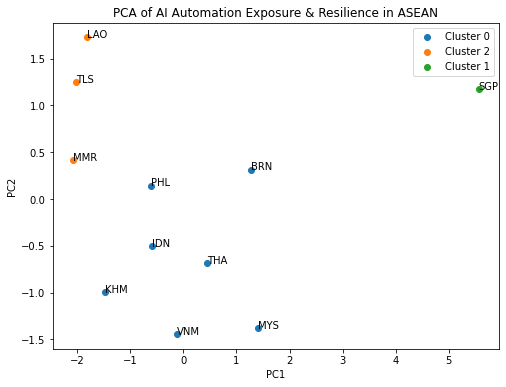

In [12]:
#Visualization

plt.figure(figsize=(8,6))
for c in df_pca['clusters'].unique():
    subset = df_pca[df_pca['clusters'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {c}')
    
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], row['economy'])
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of AI Automation Exposure & Resilience in ASEAN')
plt.show()

# Summary of Analysis

This notebook has performed a comprehensive analysis of ASEAN countries' resilience and exposure to AI automation using World Bank indicators. The key steps were:

1. **Data Collection**: Gathered 6 economic and governance indicators for 11 ASEAN countries (2015-2020)
2. **Data Preprocessing**: Cleaned, reshaped, and standardized the data
3. **Dimensionality Reduction**: Used PCA to reduce 6 dimensions to 2 principal components
4. **Clustering**: Applied K-means clustering to identify 3 distinct groups of countries
5. **Visualization**: Created a scatter plot showing country groupings in the reduced dimensional space

The clusters reveal different levels of development and institutional quality across ASEAN nations, which can inform AI policy and automation preparedness strategies.